## 一、项目背景
CDNow曾经是一家在线音乐零售平台，后被德国波泰尔斯曼娱乐集团公司出资收购，其资产总价值在最辉煌时曾超过10亿美元。本文主要通过分析CDNow网站的用户购买明细来分析该网站的用户消费行为，使运营部门在营销时更加具有针对性，从而节省成本，提升效率。

## 二、提出问题
对用户进行消费特征分析。分析框架如下：

![Image Name](https://cdn.kesci.com/upload/image/q6z13o2jy1.png?imageView2/0/w/960/h/960)



## 三.数据处理
### 3.1 导入数据

In [8]:
#导入常用的库
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')  #更改设计风格，使用自带的形式进行美化，这是一个r语言的风格

In [9]:
#导入源数据
columns = ['用户ID','购买日期','订单数','订单金额']
df = pd.read_table("d:/CDNOW.txt",names = columns,sep = '\s+')

* 加载包和数据，文件是txt，用read_table方法打开，因为原始数据不包含表头，所以需要赋予。字符串是空格分割，用\s+表示匹配任意空白符。
* 一般csv的数据分隔是以逗号的形式，但是这份数据它是通过多个空格来进行分隔
* 消费行业或者是电商行业一般是通过订单数，订单额，购买日期，用户ID这四个字段来分析的。基本上这四个字段就可以进行很丰富的分析。

In [10]:
#默认输出前五行
df.head()

,用户ID,购买日期,订单数,订单金额
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


* 观察数据，购买日期列表示时间，但现在它只是年月日组合的一串数字，数据不是时间类型，没有时间含义，需要转换。购买金额是小数。
* 数据中存在一个用户在同一天或不同天下多次订单的情况，如用户ID为2的用户就在1月12日买了两次。

### 3.2 描述性统计

In [11]:
#数值列的汇总统计信息
df.describe()

,用户ID,购买日期,订单数,订单金额
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


describe是描述统计，对用户数据特征进行整体性判断：

* 从数据的统计描述信息中可以看出，用户每个订单平均购买2.41个商品，每个订单平均消费35.89元。
* 购买商品数量的标准差为2.33，说明数据具有一定的波动性；中位数为2个商品,75分位数为3个商品，说明大部分订单的购买数量都不多。最大值在99个，数字比较高。购买金额的情况差不多，大部分订单都集中在小额。
* 一般而言，消费类的数据分布，都是长尾形态。大部分用户都是小额，然而小部分用户贡献了收入的大头，俗称二八。

## 3.3 数据处理

In [12]:
#索引，数据类型和内存信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
用户ID    69659 non-null int64
购买日期    69659 non-null int64
订单数     69659 non-null int64
订单金额    69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


查看数据类型、数据是否存在空值；原数据没有空值，很干净的数据。接下来我们要将时间的数据类型转化。
当利用pandas进行数据处理的时候，经常会遇见数据类型的问题，当拿到数据的时候，首先要确定拿到的是正确的数据类型，如果数据类型不正确需要进行数据类型的转化，再进行数据处理。

In [17]:
# 将购买日期列进行数据类型转换
df['购买日期'] = pd.to_datetime(df.购买日期,format = '%Y%m%d') #Y四位数的日期部分，y表示两位数的日期部分
df['月份'] = df.购买日期.values.astype('datetime64[M]') 
df.head()


,用户ID,购买日期,订单数,订单金额,月份
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


* pd.to_datetime可以将特定的字符串或者数字转换成时间格式，其中的format参数用于匹配。例如19970101，%Y匹配前四位数字1997，如果y小写只匹配两位数字97，%m匹配01，%d匹配01。
* 另外，小时是%h，分钟是%M，注意和月的大小写不一致，秒是%s。若是1997-01-01这形式，则是%Y-%m-%d，以此类推。
* astype也可以将时间格式进行转换，比如[M]转化成月份。我们将月份作为消费行为的主要事件窗口，选择哪种时间窗口取决于消费频率。

## 四.用户总体消费趋势分析

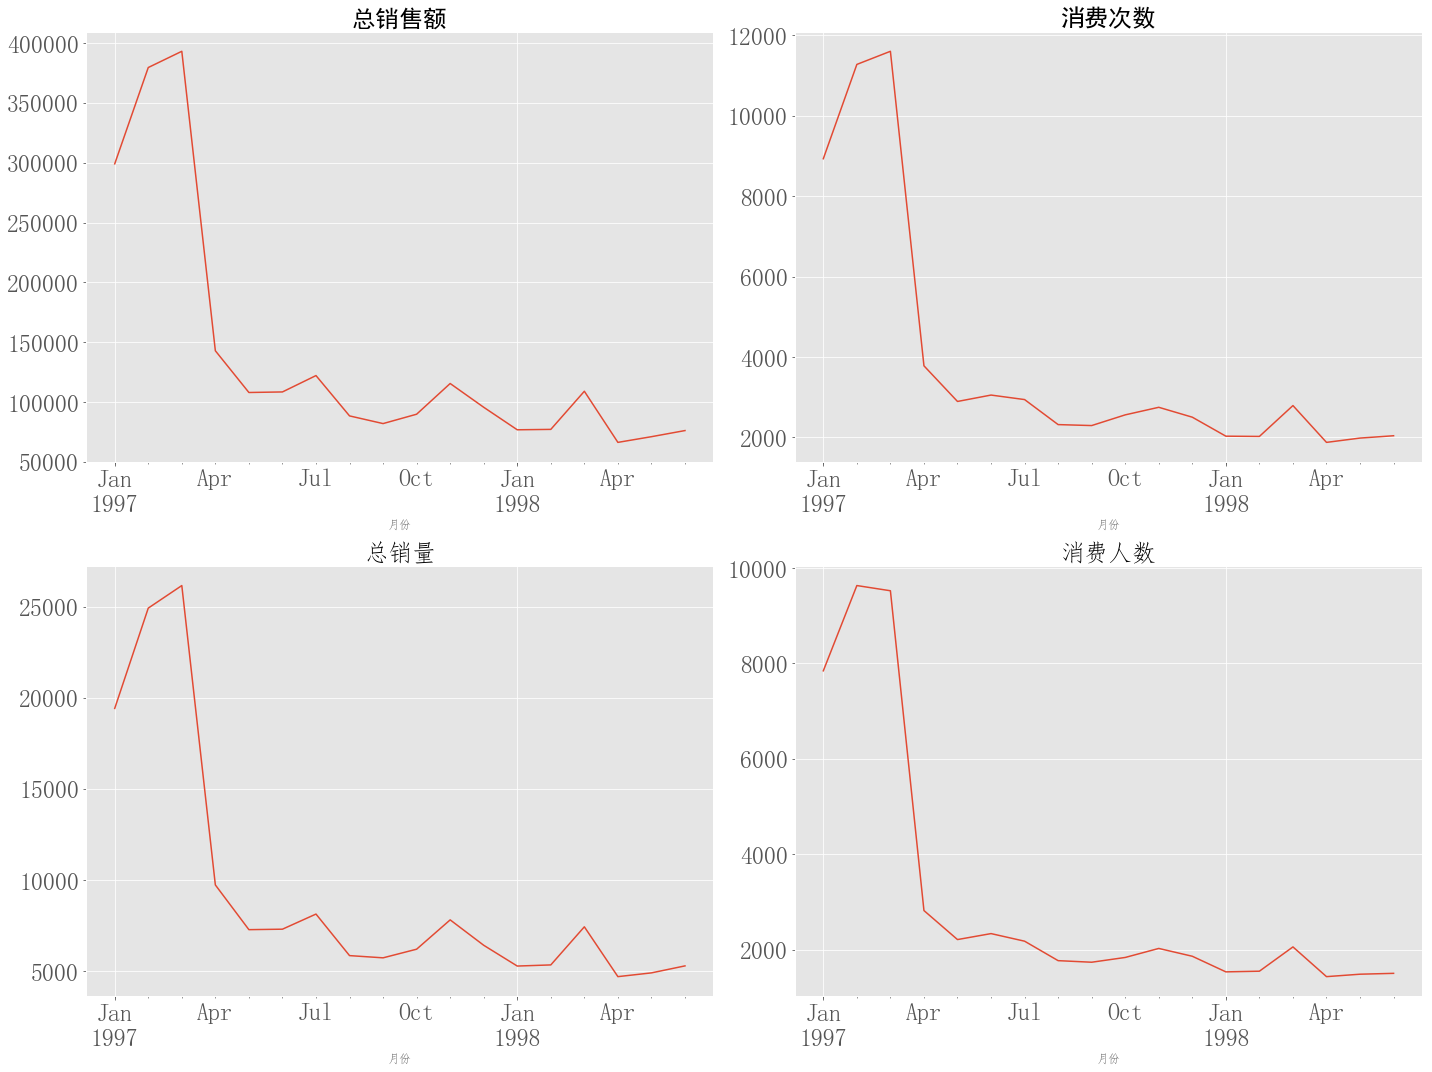

In [25]:
# 设置图的大小，添加子图
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"c:/windows/fonts/simhei.ttf")
plt.figure(figsize=(20,15))
# 每月的总销售额
plt.subplot(221)
df.groupby('月份')['订单金额'].sum().plot(fontsize=24) 
plt.title('总销售额',fontproperties=font1,fontsize=24) 
 
#每月的消费次数
plt.subplot(222)
df.groupby('月份')['购买日期'].count().plot(fontsize=24)
plt.title('消费次数',fontproperties=font1,fontsize=24) 

#每月的销量
plt.subplot(223)
df.groupby('月份')['订单数'].sum().plot(fontsize=24)
plt.title('总销量',fontsize=24)

#每月的消费人数
plt.subplot(224)
df.groupby('月份')['用户ID'].apply(lambda x:len(x.unique())).plot(fontsize=24)
plt.title('消费人数',fontsize=24)
plt.tight_layout() # 设置子图的间距
plt.show()

* 四个折线图的整体趋势基本一致，可以看出来，1997年前3个月的销量特别高，随之而来的销售额也是暴涨，在3月份之后骤然下降，接近平稳。
* 为什么会呈现这个原因呢？我们假设是用户身上出了问题，早期时间段的用户中有异常值，第二假设是各类促销营销，但这里只有消费数据，所以无法判断。
* 另一方面，在2月到3月这段期间，可以发现消费人数稍有下降，但总销量与总销售额却依然上升，是不是说明3月份的用户中有我们需要重点发展的高价值客户呢？

## 五. 用户个体消费数据分析
### 5.1 用户消费金额，消费次数的描述统计

In [26]:
# 根据用户id进行分组
group_user = df.groupby('用户ID').sum()
group_user.describe()

,订单数,订单金额
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


从用户角度看，每位用户平均购买7张CD，最多的用户购买了1033张。用户的平均消费金额（客单价）100元，标准差是240，结合分位数和最大值看，平均值才和75分位接近，肯定存在小部分的高额消费用户,这也符合二八法则。

### 5.2 用户消费金额和消费次数的散点图

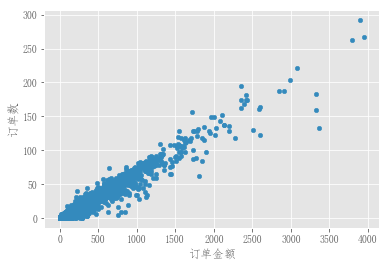

In [27]:
#查询条件：订单金额 < 4000
group_user.query('订单金额 < 4000').plot.scatter(x='订单金额',y='订单数')

* 绘制用户的散点图，用户比较健康而且规律性很强。因为这是CD网站的销售数据，商品比较单一，金额和商品量的关系也因此呈线性，没几个离群点。

### 5.3 用户消费金额的分布图（二八法则）

In [10]:
group_user.订单金额. plot.hist(bins = 20)
#bins = 20,就是分成20块，最高金额是14000，每个项就是700

<Figure size 432x288 with 1 Axes>

* 从图上看出，用户的消费呈集中趋势，可能是有个别的极大值干扰导致。
* 可以排除极大值再看看分布情况

In [11]:
group_user.query("订单金额< 800")['订单金额'].plot.hist(bins=20)

<Figure size 432x288 with 1 Axes>

筛选出了消费金额小于800的用户，我们可以看到：

* 大部分用户的消费能力并不高，将近半数的用户消费金额不超过40元，高消费用户（ >200元 ）不超过2000人。
* 从上图直方图可知，大部分用户的消费能力确实不高，绝大部分呈现集中在很低的消费档次。高消费用户在图上几乎看不到，这也确实符合消费行为的行业规律。
* 虽然有极端数据干扰，但是大部分的用户还是集中在比较低的消费档次。

### 5.4 用户消费次数的分布图（二八法则）

In [12]:
group_user.query('订单数 < 100').订单数.hist(bins = 40)

<Figure size 432x288 with 1 Axes>

* 大部分用户购买CD的数量都是在3张以内，购买大量CD的用户数量并不多。

## 六.用户消费周期分析
### 6.1 用户购买周期（按订单）

In [13]:
#每个用户的每次购买时间间隔
order_diff = df.groupby('用户ID').apply(lambda x:x['购买日期'] - x['购买日期'].shift())
order_diff.head(10)

用户ID   
1     0        NaT
2     1        NaT
      2     0 days
3     3        NaT
      4    87 days
      5     3 days
      6   227 days
      7    10 days
      8   184 days
4     9        NaT
Name: 购买日期, dtype: timedelta64[ns]

In [14]:
order_diff.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: 购买日期, dtype: object

* 平均每个用户的购买时间间隔是68天，间隔最长的是533天。想要召回用户，在60天左右的消费间隔是比较好的。
* 绝大部分用户的消费周期都低于100天。

### 6.1.2 用户消费周期分布

In [15]:
plt.figure(figsize=(15,5))
plt.hist((order_diff / np.timedelta64(1, 'D')).dropna(), bins = 50)
plt.xlabel('消费周期',fontsize=24)
plt.ylabel('频数',fontsize=24)
plt.title('用户消费周期分布图',fontsize=24);

<Figure size 1080x360 with 1 Axes>

* 典型的（指数）长尾分布，大部分用户的消费间隔确实比较短。不妨将时间召回点设为消费后立即赠送优惠券，消费后10天询问用户礼品怎么样，消费后20天提醒优惠券到期，消费后30天短信推送。

### 6.2 用户生命周期（按第一次&最后一次消费）

In [16]:
orderdt_min=df.groupby('用户ID').购买日期.min()#第一次消费
orderdt_max=df.groupby('用户ID').购买日期.max()#最后一次消费
(orderdt_max-orderdt_min).head()

用户ID
1     0 days
2     0 days
3   511 days
4   345 days
5   367 days
Name: 购买日期, dtype: timedelta64[ns]

In [17]:
#计算用户的平均生命周期
(orderdt_max-orderdt_min).mean()

Timedelta('134 days 20:55:36.987696')

* 所有用户的平均生命周期是134天，比预想的高，但是平均数不具有代表性，接下来还是看一下分布情况。

In [18]:
((orderdt_max-orderdt_min)/np.timedelta64(1,'D')).hist(bins=15)
#因为数据类型是timedelta时间，无法直接作出直方图，所以先换算成数值。
#换算的方式直接除timedelta函数即可，np.timedelta64(1, ‘D’)，D表示天，1表示1天，作为单位使用的。
#因为max-min已经表示为天了，两者相除就是周期

<Figure size 432x288 with 1 Axes>

* 大部分用户只消费了一次，所有生命周期的大头都集中在了0天。
* 但这不是我们想要的答案，不妨将只消费了一次的新客排除，来计算所有消费过两次以上的老客的生命周期。

In [19]:
#计算所有消费过两次以上的老客的生命周期
life_time = (orderdt_max - orderdt_min).reset_index()
life_time.head()

,用户ID,购买日期
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days


In [20]:
#用户生命周期分布图
plt.figure(figsize=(10,5))
life_time['life_time'] = life_time.购买日期 / np.timedelta64(1,'D')
life_time[life_time.life_time > 0].life_time.hist(bins = 100, figsize = (12,6))

<Figure size 864x432 with 1 Axes>

* 上图可见，用户生命周期呈现双峰趋势，20天内生命周期的用户是一个高峰，400至500天内生命周期的用户是另一个高峰。
* 根据此情况，应该在20天内对客户进行引导，促进其再次消费并形成消费习惯，延长其生命周期；在100至400天的用户，也要根据其特点推出有针对性的营销活动，引导其持续消费。
分析去掉0天生命周期的用户之后的用户生命周期的平均值。


In [21]:
#去掉0天生命周期的用户之后的用户生命周期的平均值
life_time[life_time.life_time>0].购买日期.mean()

Timedelta('276 days 01:04:31.344216')

* 可见，若在用户首次消费后，加强对其再次消费的引导，可将其生命周期延长至原来的两倍。

## 七.用户分层
按用户价值分层---RFM模型
为了进行精细化运营，可以利用RMF模型对用户价值指数（衡量历史到当前用户贡献的收益）进行计算，其中
最近一次消费-R：客户最近一次交易时间的间隔。R值越大，表示客户交易发生的日期越久，反之则交易发生的日期越近。
消费频率-F：客户在最近一段时间内交易的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
消费金额-M：客户在最近一段时间内交易的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。
根据上述三个维度，对客户做细分

In [22]:
rfm = df.pivot_table(index = '用户ID',
                     values = ['订单金额','购买日期','订单数'],
                     aggfunc = {'订单金额':'sum',
                                '购买日期':'max',
                                '订单数':'sum'})
rfm.head()

# 日期的最大值与当前日期的差值为R
rfm['R'] = (rfm['购买日期'].max() - rfm['购买日期']) / np.timedelta64(1,'D')
rfm.rename(columns = {'订单金额':'M',
                     '订单数':'F'},
          inplace=True)

# 构建rfm模型公式
def get_rfm(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')
    label = level['R'] + level['F'] + level['M']
    d = {'111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要挽留客户',
        '001':'重要发展客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般挽留客户',
        '000':'一般发展客户'}
    
    result = d[label]
    return result
rfm['label'] = rfm[['R','F','M']].apply(lambda x:(x-x.mean()) / x.std()).apply(get_rfm,axis=1)
rfm.head()
#求和
rfm.groupby('label').sum()

,F,M,R
label,,,
一般价值客户,650,7181.28,36295.0
一般保持客户,1712,19937.45,29448.0
一般发展客户,13977,196971.23,591108.0
一般挽留客户,29346,438291.81,6951815.0
重要价值客户,11121,167080.83,358363.0
重要保持客户,107789,1592039.62,517267.0
重要发展客户,2023,45785.01,56636.0
重要挽留客户,1263,33028.40,114482.0


* M列中不同层次客户的消费累计金额，重要保持客户的累计消费金额为159203.62，排名最高

In [23]:
rfm.groupby('label').size()

label
一般价值客户       77
一般保持客户      206
一般发展客户     3300
一般挽留客户    14074
重要价值客户      787
重要保持客户     4554
重要发展客户      331
重要挽留客户      241
dtype: int64

* 以上为不同层次用户的消费人数，一般挽留用户的消费人数排名第一，有14074人，重要保持客户排名第二，有4554人，与一般挽留用户差距比较大，但累计消费金额最多，业务方可以根据结果对客户分类运营，降低营销成本，提高ROI。

## 八.用户质量分析

In [24]:
a = df.groupby('用户ID')['购买日期'].agg(['min','max']).reset_index()
new_old = (a['min'] == a['max']).value_counts().values

plt.pie(x = new_old,
       autopct = '%.1f%%',
       shadow = True,
       explode = [0.08,0],
       textprops = {'fontsize' : 11})
plt.axis('equal') 
plt.legend(['仅消费一次','多次消费'])

<Figure size 432x288 with 1 Axes>

* 有超过一半的用户仅消费了一次，这也说明了运营不利，留存效果不好。

* 复购率的定义：在某时间窗口内消费两次及以上的用户在总消费用户中占比。这里的时间窗口是月，如果一个用户在同一天下了两笔订单，这里也将他算作复购用户

In [25]:
#每个用户在每月的订单数
pivoted_df=df.pivot_table(index='用户ID',columns='月份',values='购买日期',#pivot_table透视表
                       aggfunc='count').fillna(0)#某些用户在某月没有消费过，用nan表示，这里用0填充

pivoted_df.head()

月份,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
用户ID,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#转换：消费2次以上记为1，消费1次记为0，消费0次记为NAN  
#applymap针对dataframe所有数据
pivoted_df_transf=pivoted_df.applymap(lambda x: 1 if x>1 else np.nan if x==0 else 0)
pivoted_df_transf.head()

月份,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
用户ID,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [27]:
#count统计所有非空数据个数表示总消费用户数，sum计算非0数据的和表示消费两次以上的用户数
df_duplicate =pd.DataFrame(pivoted_df_transf.sum()/pivoted_df_transf.count()).reset_index()
df_duplicate.columns = ['Date', 'DuplicatedRate']
df_duplicate['Date'] = df_duplicate.Date.astype(str).apply(lambda x:x[:-3])

plt.figure(figsize = (15,6))
plt.plot(df_duplicate.Date, df_duplicate.DuplicatedRate)
plt.xlabel('时间', fontsize=24)
plt.ylabel('复购率',fontsize=24)
# plt.ylim(0,1)
plt.title('复购率的变化',fontsize=24)

Text(0.5, 1.0, '复购率的变化')

<Figure size 1080x432 with 1 Axes>

* 说明：图上可以看出复购率在早期，因为大量新用户加入的关系，新客的复购率并不高，如1月新客们的复购率只有6%左右。而在后期，这时的用户都是大浪淘沙剩下的老客，复购率比较稳定，在20%左右。单看新客和老客，复购率有三倍左右的差距。

回购率：是某一个时间窗口内消费的用户，在下一个时间窗口仍旧消费的占比。比如，我1月消费用户1000，他们中有300个2月依然消费，回购率是30%。

In [28]:
#回购率
#每个用户每个月平均消费金额
pivoted_money=df.pivot_table(index='用户ID',columns='月份',values='订单金额',
                             aggfunc='mean').fillna(0)

columns_month=df.月份.sort_values().astype('str').unique()
pivoted_money.columns=columns_month
pivoted_money.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
用户ID,,,,,,,,,,,,,,,,,,
1,11.77,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
2,44.50,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
3,20.76,0.0,20.76,19.54,0.00,0.00,0.00,0.00,0.00,0.0,39.205,0.000,0.00,0.0,0.0,0.0,16.99,0.0
4,29.53,0.0,0.00,0.00,0.00,0.00,0.00,14.96,0.00,0.0,0.000,26.480,0.00,0.0,0.0,0.0,0.00,0.0
5,21.65,38.9,0.00,45.55,38.71,26.14,28.14,0.00,40.47,0.0,0.000,43.465,37.47,0.0,0.0,0.0,0.00,0.0


In [29]:
#将有消费的记为1，没有消费的记为0
pivoted_purchase=pivoted_money.applymap(lambda x:1 if x>0 else 0)
pivoted_purchase.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
用户ID,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [30]:
#如果本月进行消费，下月也进行消费，则记为1；如果下月没有消费，则记为0，若本月没有记为消费，则记为nan
def purchase_return(data):
    status=[]
    for i in range(17):#循环17个月
        if data[i]==1:#若本月消费
            if data[i+1]==1:#下个月也消费
                status.append(1)#就记为1
            if data[i+1]==0:#下个月不消费，就记为0
                status.append(0)
        else:
            status.append(np.nan)
    status.append(np.nan)
    return pd.Series(status, index=columns_month)

pivoted_purchase_return=pivoted_purchase.apply(purchase_return,axis=1)#axis=1表示计算方向在行的方向上，左右运算
pivoted_purchase_return.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
用户ID,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [31]:
df_purchase = (pivoted_purchase_return.sum() / pivoted_purchase_return.count()).reset_index()
df_purchase.columns = ['Date', 'PurchaseRate']
df_purchase['Date'] = df_purchase.Date.astype(str).apply(lambda x:x[:-3])

plt.figure(figsize = (15,5))
plt.plot(df_purchase.Date, df_purchase.PurchaseRate)
plt.xlabel('时间', fontsize=24)
plt.ylabel('回购率', fontsize=24)
plt.title('回购率的变化', fontsize=24);

<Figure size 1080x360 with 1 Axes>

* 上图可以看出，在初期用户的回购率并不高，1月的回购率只有15%左右，4月份起回购率稳定在30%左右。
* 从每月有回购消费的用户数数据可以看出，回购用户数整体有下降趋势。
* 对回购率的分析，再次说明了对于新用户，在其第一次消费后的三个月内是一段重要的时期，需要营销策略积极引导其再次消费及持续消费。
* 另外，对于有持续消费的老客，也要适时推出反馈老客户的优惠活动，以加强老客的忠诚度。